## Setup - Importing Libraries

In [ ]:
#!pip install lightfm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
import joblib


## 1. Data Preparation


In [ ]:
# Load datasets
purchase_data = pd.read_csv("/content/customer_purchase_data.csv")
product_metadata = pd.read_csv("/content/generated_product_metadata.csv")
activity_data = pd.read_csv("/content/customer_activity_data.csv")
demographics_data = pd.read_csv("/content/customer_demographics_data.csv")

# Data cleaning
#Formatting Price and Date
purchase_data['Price'] = purchase_data['Price'].str.replace(r'[^0-9.$]', '', regex=True).str.extract(r'(\$\d+\.\d{2})')[0]
purchase_data['Price'] = purchase_data['Price'].str.replace('$', '').astype(float)
purchase_data['Purchase_Date'] = pd.to_datetime(purchase_data['Purchase_Date'], format='%Y-%m-%d')

#Cleaning Category
purchase_data['Category'] = purchase_data['Category'].str.split('|').str[0].str.strip()

#Formatting Price
product_metadata['Price'] = product_metadata['Price'].astype(str)
product_metadata['Price'] = product_metadata['Price'].str.replace(r'[^0-9.$]', '', regex=True).str.extract(r'(\$\d+\.\d{2})')[0]
product_metadata['Price'] = product_metadata['Price'].str.replace('$', '').astype(float)

#Cleaning Category
product_metadata['Category'] = product_metadata['Category'].str.split('|').str[0].str.strip()

# Feature Engineering
purchase_data['Total_Spending'] = purchase_data['Price'] * purchase_data['Quantity']
activity_data['Engagement_Score'] = activity_data['Clicks'] / activity_data['Time_Spent_min']
purchase_data = purchase_data.dropna()

# Merge for Analysis
merged_data = purchase_data.merge(activity_data, on=['User_ID', 'Product_ID'], how='left')
merged_data = merged_data.merge(demographics_data, on='User_ID', how='left')

# Encoding categorical variables using label encoding
label_encoder = LabelEncoder()
merged_data['Location'] = label_encoder.fit_transform(merged_data['Location'])
merged_data['Category'] = label_encoder.fit_transform(merged_data['Category'])
merged_data['Gender'] = merged_data['Gender'].map({'Male': 1, 'Female': 0})

# Save cleaned datasets for modularity
purchase_data.to_csv("cleaned_customer_purchase_data.csv", index=False)
merged_data.to_csv("merged_data.csv", index=False)



## 2. Exploratory Data Analysis (EDA)

In [ ]:
# Check for missing values and statistical summaries
print(purchase_data.isnull().sum())
print(demographics_data.describe())

User_ID           0
Product_ID        0
Product_Name      0
Category          0
Price             0
Purchase_Date     0
Quantity          0
Total_Spending    0
dtype: int64
            User_ID          Age         Income
count  5.891000e+03  5891.000000    5891.000000
mean   1.003025e+06    43.989306   75747.166826
std    1.743379e+03    15.243905   25748.335267
min    1.000001e+06    18.000000   30005.600000
25%    1.001518e+06    31.000000   53761.125000
50%    1.003026e+06    44.000000   75996.820000
75%    1.004532e+06    57.000000   98142.080000
max    1.006040e+06    70.000000  119998.650000


### 2.1  Analyzing Customer Demographics

Key Questions to Address:

- What is the age distribution of the customers?
- Are there any significant differences in purchasing behavior by gender?
- How is income distributed, and does it correlate with purchase frequency or total spending?
- What are the most common customer locations?

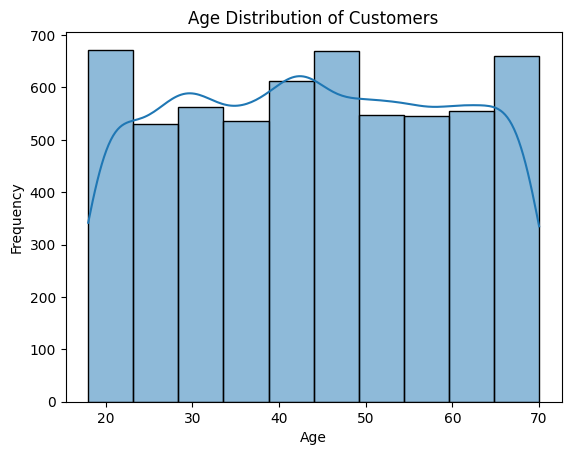

In [ ]:
# Age distribution
sns.histplot(demographics_data['Age'], bins=10, kde=True)
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


People in age groups 20s, 40s to 50s and 65s to 70s seem to purchase more compared to other age groups.


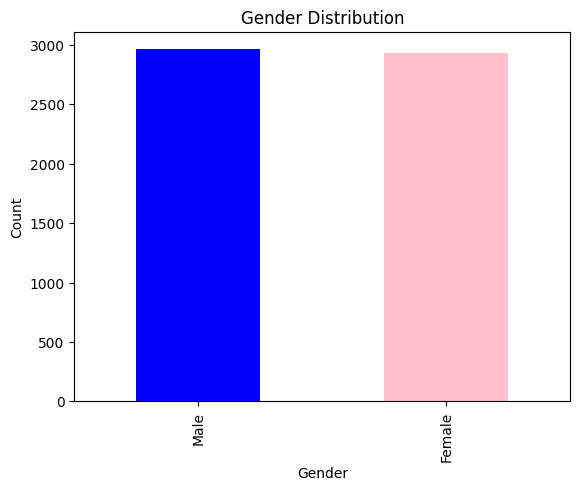

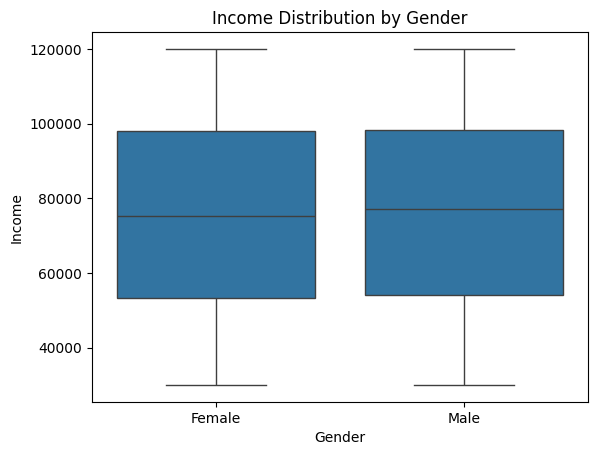

In [ ]:
# Gender distribution
gender_counts = demographics_data['Gender'].value_counts()
gender_counts.plot(kind='bar', color=['blue', 'pink'])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Income distribution
sns.boxplot(x='Gender', y='Income', data=demographics_data)
plt.title("Income Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Income")
plt.show()


Gender does not have a impact on purchasing behaviour or income in this dataset.

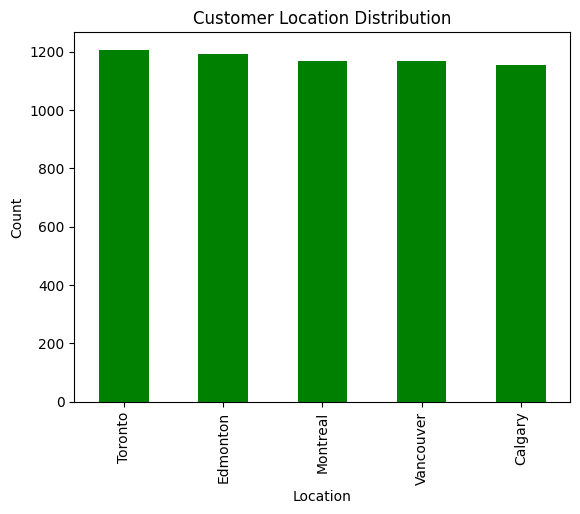

In [ ]:

# Location analysis
location_counts = demographics_data['Location'].value_counts()
location_counts.plot(kind='bar', color='green')
plt.title("Customer Location Distribution")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()


Toronto is the leading city in terms of purchases. Other cities are in par with the leading city and has very minor differences.

### 2.2 Analyze Purchase Behavior
Key Questions to Address:

- What are the most purchased product categories?
- What is the average spending per user?
- What is the overall revenue generated by the dataset?
- Are there any outliers in terms of price or quantity?

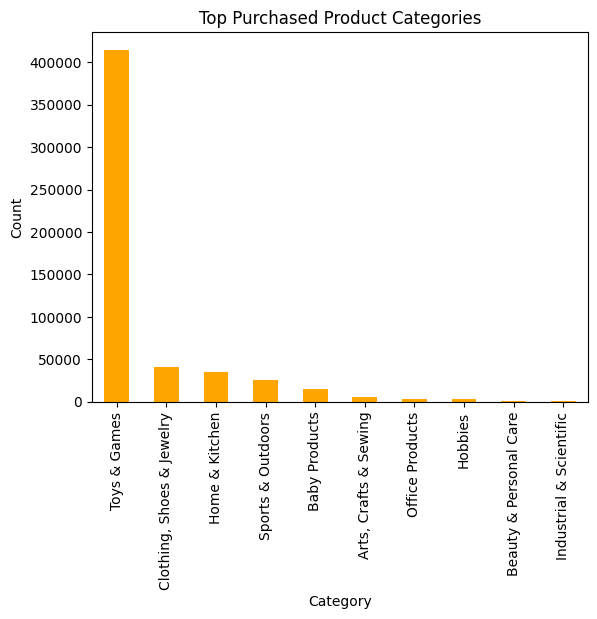

In [ ]:
# Top 10 purchased categories
top_categories = purchase_data['Category'].value_counts().head(10)
top_categories.plot(kind='bar', color='orange')
plt.title("Top Purchased Product Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


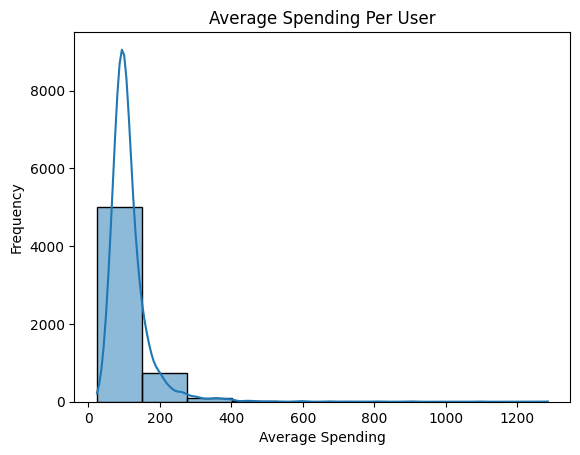

In [ ]:
# Average spending per user
avg_spending = purchase_data.groupby('User_ID')['Total_Spending'].mean()
sns.histplot(avg_spending, bins=10, kde=True)
plt.title("Average Spending Per User")
plt.xlabel("Average Spending")
plt.ylabel("Frequency")
plt.show()


Most users spend under 400 CAD while there are instances of purchases upto 1200 CAD.


In [ ]:
# Total revenue
total_revenue = purchase_data['Total_Spending'].sum()
print(f"Total Revenue Generated in year 2024 to 2025: ${total_revenue:.2f}")

Total Revenue Generated in year 2024 to 2025: $62924725.25


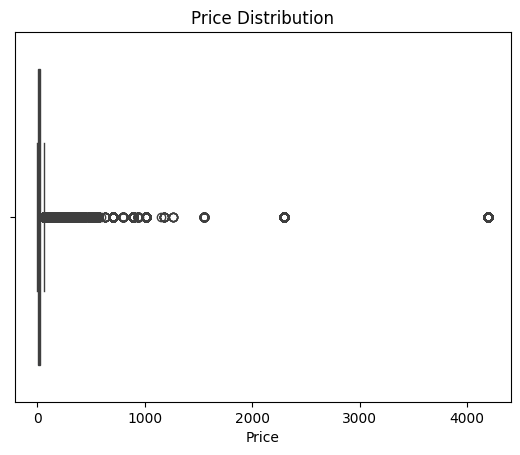

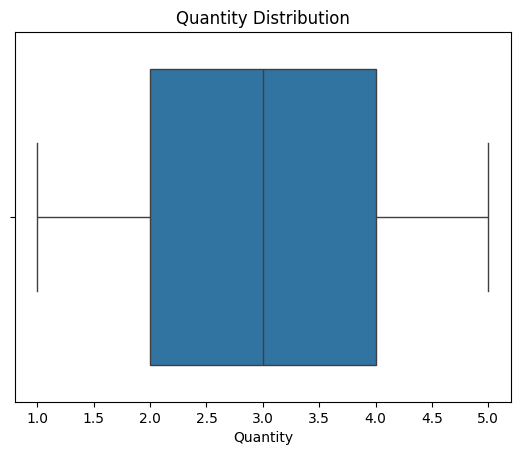

In [ ]:
# Price and quantity outliers
sns.boxplot(x=purchase_data['Price'])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.show()

sns.boxplot(x=purchase_data['Quantity'])
plt.title("Quantity Distribution")
plt.xlabel("Quantity")
plt.show()

### 2.3 Identify Product Preferences

Key Questions to Address:

- Which products are most frequently purchased?
- Is there a relationship between product price and purchase frequency?

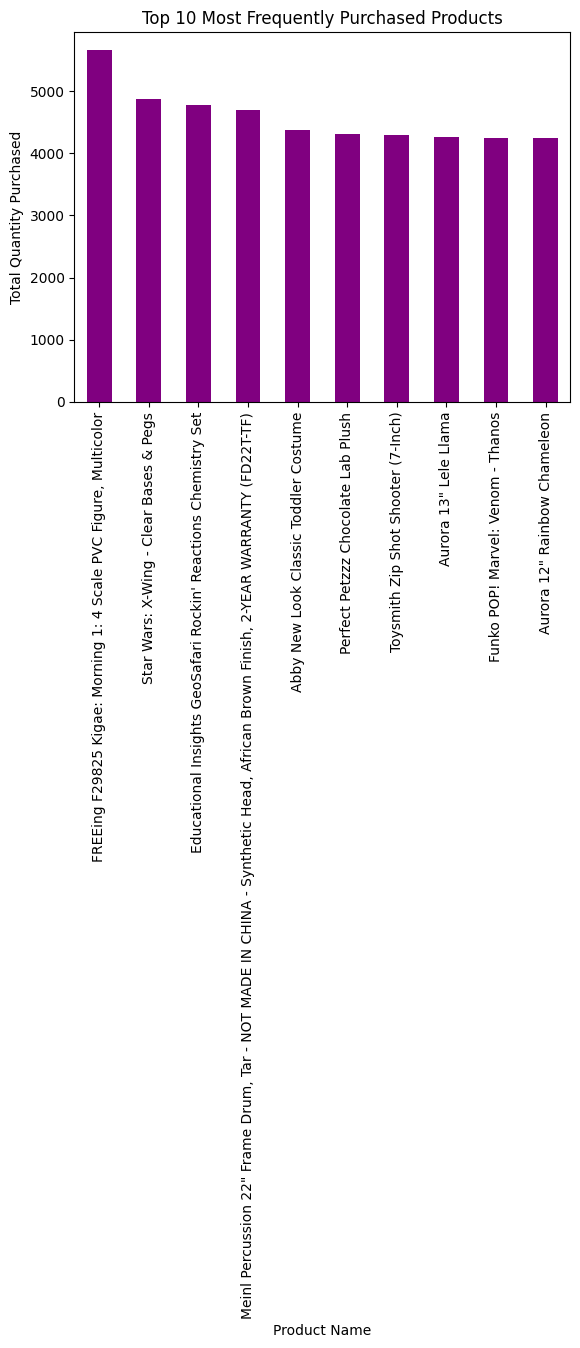

In [ ]:
# Most frequently purchased products
top_products = purchase_data.groupby('Product_Name')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', color='purple')
plt.title("Top 10 Most Frequently Purchased Products")
plt.xlabel("Product Name")
plt.ylabel("Total Quantity Purchased")
plt.show()



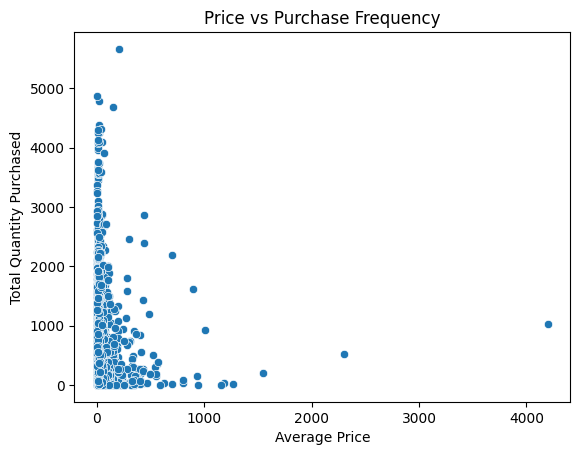

In [ ]:
# Price vs Purchase Frequency
price_vs_quantity = purchase_data.groupby('Product_Name').agg({'Price': 'mean', 'Quantity': 'sum'})
sns.scatterplot(x='Price', y='Quantity', data=price_vs_quantity)
plt.title("Price vs Purchase Frequency")
plt.xlabel("Average Price")
plt.ylabel("Total Quantity Purchased")
plt.show()

There seems to be a relation between product's price and purchase frequency. From this graph, it can be inferred that products with high price and compared rarely compared to products with low price.

### 2.4 Identify Patterns

Key Steps:

- Analyze seasonal purchase trends by aggregating data by month or quarter.
- Correlation analysis between income and spending.

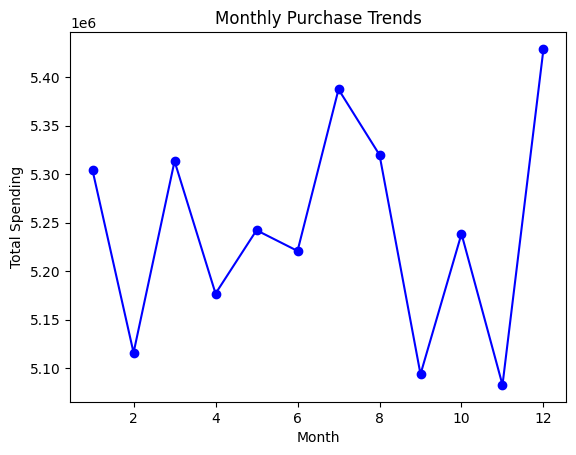

In [ ]:
# Seasonal purchase trends
purchase_data['Month'] = purchase_data['Purchase_Date'].dt.month
monthly_trends = purchase_data.groupby('Month')['Total_Spending'].sum()

monthly_trends.plot(kind='line', marker='o', color='blue')
plt.title("Monthly Purchase Trends")
plt.xlabel("Month")
plt.ylabel("Total Spending")
plt.show()


The sales is peaked during December which might be due to christmas and new year season. Second highest peak is during July followed by March and January.

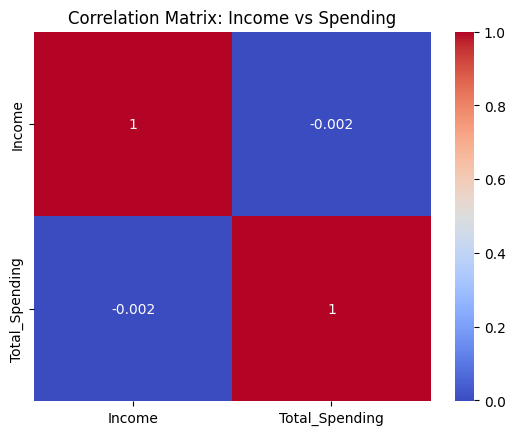

In [ ]:
# Correlation analysis
correlation_data = merged_data[['Income', 'Total_Spending']]
correlation_matrix = correlation_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Income vs Spending")
plt.show()


There is no correlation between Spending patterns and income.

## 3. Customer Segmentation

### 3.1 Feature Calculation for Segmentation

- Purchase Frequency: The total number of purchases a customer made.
- Total Spend: The total amount a customer spent.
- Spending by Category: How much a customer has spent in different product categories.

In [ ]:
#purchase frequency and total spend for each customer
user_summary = merged_data.groupby('User_ID').agg(
    total_spent=('Total_Spending', 'sum'),
    purchase_frequency=('User_ID', 'count')
).reset_index()

#spending by product category
category_spend = merged_data.groupby(['User_ID', 'Category'])['Total_Spending'].sum().unstack().fillna(0)

# Combining the calculated features into one summary dataframe
user_summary = pd.merge(user_summary, category_spend, on='User_ID')

# Merging with demographic data
user_summary = pd.merge(user_summary, demographics_data, on='User_ID')

# Display user_summary
user_summary.head()

,User_ID,total_spent,purchase_frequency,0,1,2,3,4,5,6,...,15,16,17,18,19,20,Age,Gender,Location,Income
0,1000001,4788.95,35,0.00,0.0,0.00,92.44,274.05,0.0,0.0,...,0.0,0.0,74.75,0.0,4311.97,0.0,27,Female,Edmonton,114261.73
1,1000002,28733.18,77,15.20,0.0,141.00,0.00,207.30,0.0,0.0,...,0.0,0.0,600.91,0.0,25896.38,0.0,24,Female,Toronto,75991.96
2,1000003,3917.26,29,0.00,0.0,0.00,0.00,51.12,0.0,0.0,...,0.0,0.0,0.00,0.0,3712.45,0.0,54,Female,Calgary,31070.43
3,1000004,1758.71,14,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,1621.25,0.0,22,Male,Edmonton,62885.70
4,1000005,11146.02,106,201.88,0.0,389.23,0.00,1206.42,0.0,0.0,...,0.0,0.0,865.92,0.0,7513.87,0.0,43,Male,Toronto,85123.37



### 3.2 Feature Scaling

In [ ]:
# Selecting the features for clustering
features = user_summary[['total_spent', 'purchase_frequency', 'Age', 'Income'] + list(category_spend.columns)]
features.columns = features.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


### 3.3 K-Means Clustering

Finding Optimal Clusters with Elbow Method:

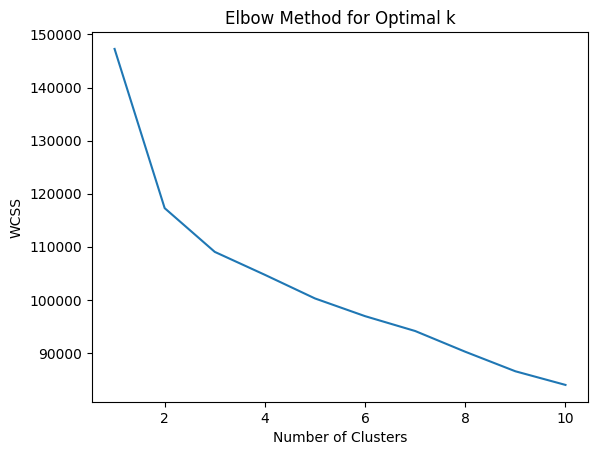

In [ ]:
# Find the optimal number of clusters using the elbow method
wcss = []  # Within-cluster sum of squares (WCSS)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve to find the optimal k
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


Optimum number of clusters: 3

In [ ]:
# Fitting K-Means with the chosen number of clusters (k=3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
user_summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the clusters
print(user_summary.head())


   User_ID  total_spent  purchase_frequency       0    1       2      3  \
0  1000001      4788.95                  35    0.00  0.0    0.00  92.44   
1  1000002     28733.18                  77   15.20  0.0  141.00   0.00   
2  1000003      3917.26                  29    0.00  0.0    0.00   0.00   
3  1000004      1758.71                  14    0.00  0.0    0.00   0.00   
4  1000005     11146.02                 106  201.88  0.0  389.23   0.00   

         4    5    6  ...   16      17   18        19   20  Age  Gender  \
0   274.05  0.0  0.0  ...  0.0   74.75  0.0   4311.97  0.0   27  Female   
1   207.30  0.0  0.0  ...  0.0  600.91  0.0  25896.38  0.0   24  Female   
2    51.12  0.0  0.0  ...  0.0    0.00  0.0   3712.45  0.0   54  Female   
3     0.00  0.0  0.0  ...  0.0    0.00  0.0   1621.25  0.0   22    Male   
4  1206.42  0.0  0.0  ...  0.0  865.92  0.0   7513.87  0.0   43    Male   

   Location     Income  Cluster  
0  Edmonton  114261.73        0  
1   Toronto   75991.96        

### 3.4 Visualizing Clusters

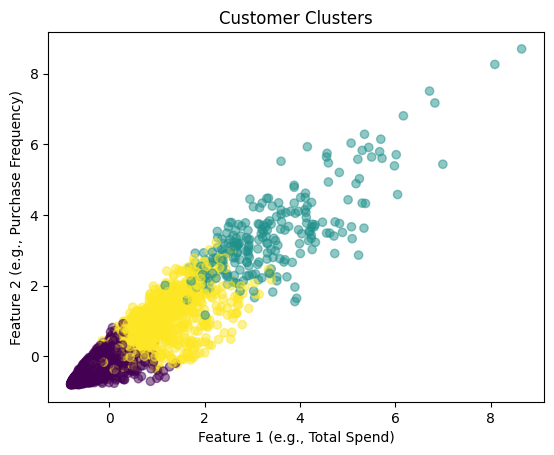

In [ ]:
# Visualize Clusters
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=user_summary['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Customer Clusters')
plt.xlabel('Feature 1 (e.g., Total Spend)')
plt.ylabel('Feature 2 (e.g., Purchase Frequency)')
plt.show()

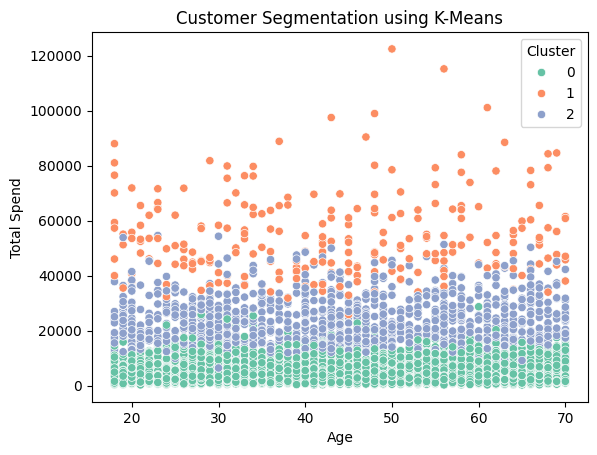

In [ ]:
# Visualizing the clusters based on Age vs. Total Spend
sns.scatterplot(x=user_summary['Age'], y=user_summary['total_spent'], hue=user_summary['Cluster'], palette='Set2')
plt.title("Customer Segmentation using K-Means")
plt.xlabel("Age")
plt.ylabel("Total Spend")
plt.show()


In [ ]:
# Saving segmented customer data for further use
user_summary.to_csv("segmented_customers.csv", index=False)

## 4. Recommendation Engine

### 4.1 Data Preparation for Recommendation


LightFM expects continuous integer values starting from 0 for both users and items. Therefore, map the User_ID and Product_ID to indices starting from 0.

In [ ]:
# Reindex User_ID and Product_ID to continuous integers starting from 0
user_map = {user: idx for idx, user in enumerate(merged_data['User_ID'].unique())}
product_map = {product: idx for idx, product in enumerate(merged_data['Product_ID'].unique())}

# Map User_ID and Product_ID in the merged_data
merged_data['User_Index'] = merged_data['User_ID'].map(user_map)
merged_data['Product_Index'] = merged_data['Product_ID'].map(product_map)

# Check the new mappings
print(merged_data[['User_ID', 'User_Index', 'Product_ID', 'Product_Index']].head())

# Save reverse mapping for converting back
reverse_user_map = {idx: user for user, idx in user_map.items()}
reverse_product_map = {idx: product for product, idx in product_map.items()}

   User_ID  User_Index Product_ID  Product_Index
0  1000001           0  P00069042              0
1  1000001           0  P00248942              1
2  1000001           0  P00087842              2
3  1000001           0  P00085442              3
4  1000002           1  P00285442              4


User-Item Interaction Matrix: This matrix shows which products a user interacted with and how (e.g., purchase frequency, rating, or engagement)

In [ ]:
# Create LightFM Dataset object
dataset = Dataset()

# Fit the dataset with users and items
dataset.fit(
    merged_data['User_Index'],  # Users
    merged_data['Product_Index']  # Items
)

# Build interaction matrix
(interactions, weights) = dataset.build_interactions(
    [(row['User_Index'], row['Product_Index'], row['Total_Spending']) for _, row in merged_data.iterrows()]
)

# Display interaction matrix shape
print(f"Interaction matrix shape: {interactions.shape}")

Interaction matrix shape: (5891, 3631)


### 4.2 Collaborative Filtering (Matrix Factorization using LightFM)

Collaborative filtering makes recommendations based on user-item interactions, even without knowing the product details.

In [ ]:
from lightfm import LightFM

# Instantiate the LightFM model
model = LightFM(loss='warp', random_state=42)

# Train the model
model.fit(interactions, epochs=30, num_threads=2, verbose=True)

# Evaluate the model
train_precision = precision_at_k(model, interactions, k=5).mean()
train_auc = auc_score(model, interactions).mean()

print(f"Precision@K: {train_precision:.4f}")
print(f"AUC Score: {train_auc:.4f}")

Epoch: 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


Precision@K: 0.4164
AUC Score: 0.9251


- WARP loss is used for learning user-item interactions, focusing on ranking pairs of products (which is useful for recommendation tasks).


- The model is trained for 30 epochs (iterations).

Function to get recommendations for a User:

In [ ]:
# Recommendation for a single user
def recommend_for_user(user_id, model, interactions, num_recommendations=5):
    user_idx = user_map[user_id]
    scores = model.predict(user_idx, np.arange(interactions.shape[1]))
    top_items = np.argsort(-scores)[:num_recommendations]
    return [reverse_product_map[item] for item in top_items]


# Batch Recommendations
def recommend_for_all_users(model, interactions, num_recommendations=5):
    recommendations = {}
    for user_idx in range(interactions.shape[0]):
        scores = model.predict(user_idx, np.arange(interactions.shape[1]))
        top_items = np.argsort(-scores)[:num_recommendations]
        user_id = reverse_user_map[user_idx]
        recommendations[user_id] = [reverse_product_map[item] for item in top_items]
    return recommendations


In [ ]:
# Example: Recommend for a specific user
example_user_id = list(user_map.keys())[0]
recommended_products = recommend_for_user(example_user_id, model, interactions)
print(f"Recommended products for user {example_user_id}: {recommended_products}")

# Generating batch recommendations
all_user_recommendations = recommend_for_all_users(model, interactions)


Recommended products for user 1000001: ['P00058242', 'P00119142', 'P00085942', 'P00102642', 'P0096542']


### 4.3. Content-Based Filtering ( with TF-IDF)
In Content-Based Filtering, we recommend products similar to those a user has shown interest in, based on product features (e.g., category, price, description).

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization for Product Descriptions
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(product_metadata['Product_Description'])

# Compute cosine similarity between products
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Function to recommend products based on content similarity
def content_based_recommendation(product_id, top_n=5):
    product_idx = product_map[product_id]
    similarity_scores = list(enumerate(cosine_sim[product_idx]))
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    recommended_indices = [idx for idx, _ in sorted_scores]
    recommended_product_ids = [list(product_map.keys())[list(product_map.values()).index(idx)] for idx in recommended_indices]
    return recommended_product_ids

# Example Recommendation
example_product_id = list(product_map.keys())[0]
recommended_products = content_based_recommendation(example_product_id, top_n=5)
print(f"Products similar to {example_product_id}: {recommended_products}")


Products similar to P00069042: ['P00157342', 'P00265042', 'P00090642', 'P00046142', 'P00006142']


### 4.4 Hybrid Recommendation System

Hybrid recommendation systems combine collaborative and content-based filtering to provide more accurate and diverse recommendations.


In [ ]:
def hybrid_recommendation(user_id, interaction_matrix, model, product_metadata, tfidf_cosine_sim, user_map, product_map, num_recommendations=10):
    """
    Combine collaborative filtering and content-based filtering for recommendations.

    Parameters:
        user_id (int): The user ID for whom recommendations are generated.
        interaction_matrix (csr_matrix): User-item interaction matrix.
        model (LightFM): Trained LightFM model.
        product_metadata (DataFrame): Product metadata.
        tfidf_cosine_sim (ndarray): Cosine similarity matrix from TF-IDF.
        user_map (dict): Mapping of user IDs to indices.
        product_map (dict): Mapping of product IDs to indices.
        num_recommendations (int): Number of recommendations to generate.

    Returns:
        list: Recommended product IDs.
    """
    # Step 1: Collaborative filtering recommendations
    user_idx = user_map[user_id]
    scores = model.predict(user_idx, np.arange(interaction_matrix.shape[1]))
    top_collab_indices = np.argsort(-scores)[:num_recommendations]

    # Map collaborative indices to Product IDs
    reverse_product_map = {v: k for k, v in product_map.items()}
    collaborative_recs = [reverse_product_map[idx] for idx in top_collab_indices]

    # Step 2: Content-based recommendations using TF-IDF cosine similarity
    content_recs = set()
    for product_id in collaborative_recs:
        if product_id in product_map:
            product_idx = product_map[product_id]
            similarity_scores = list(enumerate(tfidf_cosine_sim[product_idx]))
            sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations + 1]
            similar_indices = [idx for idx, _ in sorted_scores]
            similar_products = [reverse_product_map[idx] for idx in similar_indices if idx in reverse_product_map]
            content_recs.update(similar_products)

    # Step 3: Combine collaborative and content-based recommendations
    all_recs = list(set(collaborative_recs) | content_recs)
    return all_recs[:num_recommendations]


In [ ]:
# Example: Get hybrid recommendations for a user
example_user_id = list(user_map.keys())[0]
hybrid_recs = hybrid_recommendation(
    user_id=example_user_id,
    interaction_matrix=interactions,
    model=model,
    product_metadata=product_metadata,
    tfidf_cosine_sim=cosine_sim,
    user_map=user_map,
    product_map=product_map)
print(f"Hybrid recommendations for User {example_user_id}: {hybrid_recs}")


Hybrid recommendations for User 1000001: ['P00071142', 'P00013342', 'P00158142', 'P00275942', 'P00060742', 'P00102642', 'P00247542', 'P00073642', 'P00136042', 'P00049242']


In [ ]:
## Final Evaluation

# Evaluate precision and AUC for the hybrid recommendation system
# Collaborative filtering evaluation
train_precision = precision_at_k(model, interactions, k=5).mean()
train_auc = auc_score(model, interactions).mean()

# Display evaluation results
print(f"Collaborative Filtering - Precision@K: {train_precision:.4f}")
print(f"Collaborative Filtering - AUC: {train_auc:.4f}")

# Example hybrid recommendation evaluation
print(f"Example hybrid recommendations for User {example_user_id}: {hybrid_recs}")

Collaborative Filtering - Precision@K: 0.4164
Collaborative Filtering - AUC: 0.9251
Example hybrid recommendations for User 1000001: ['P00071142', 'P00013342', 'P00158142', 'P00275942', 'P00060742', 'P00102642', 'P00247542', 'P00073642', 'P00136042', 'P00049242']


In [ ]:
import joblib

# Save the trained LightFM model and mappings
joblib.dump(model, 'lightfm_model.pkl')
joblib.dump(user_map, 'user_map.pkl')
joblib.dump(product_map, 'product_map.pkl')
joblib.dump(cosine_sim, 'tfidf_cosine_sim.pkl')
joblib.dump(interactions, 'interaction_matrix.pkl')

# Load the saved model and mappings
model = joblib.load('lightfm_model.pkl')
user_map = joblib.load('user_map.pkl')
product_map = joblib.load('product_map.pkl')
cosine_sim = joblib.load('tfidf_cosine_sim.pkl')
interaction_matrix = joblib.load('interaction_matrix.pkl')

# Example usage after loading
example_user_id = list(user_map.keys())[0]
hybrid_recs = hybrid_recommendation(
    user_id=example_user_id,
    interaction_matrix=interactions,
    model=model,
    product_metadata=product_metadata,
    tfidf_cosine_sim=cosine_sim,
    user_map=user_map,
    product_map=product_map
)
print(f"Hybrid recommendations for User {example_user_id}: {hybrid_recs}")



Hybrid recommendations for User 1000001: ['P00071142', 'P00013342', 'P00158142', 'P00275942', 'P00060742', 'P00102642', 'P00247542', 'P00073642', 'P00136042', 'P00049242']


In [ ]:
import joblib

# Define file paths for saving
file_paths = {
    'model': 'lightfm_model.joblib',
    'user_map': 'user_map.joblib',
    'product_map': 'product_map.joblib',
    'reverse_user_map': 'reverse_user_map.joblib',
    'reverse_product_map': 'reverse_product_map.joblib',
    'interaction_matrix': 'interaction_matrix.joblib',
    'cosine_similarity': 'tfidf_cosine_similarity.joblib',
    'product_metadata': 'product_metadata.csv',
    'segmented_customers': 'segmented_customers.csv',
}

# Save the LightFM model
joblib.dump(model, file_paths['model'])

# Save mappings for user and product indices
joblib.dump(user_map, file_paths['user_map'])
joblib.dump(product_map, file_paths['product_map'])
joblib.dump(reverse_user_map, file_paths['reverse_user_map'])
joblib.dump(reverse_product_map, file_paths['reverse_product_map'])

# Save the interaction matrix
joblib.dump(interactions, file_paths['interaction_matrix'])

# Save the TF-IDF cosine similarity matrix
joblib.dump(cosine_sim, file_paths['cosine_similarity'])

# Save product metadata and segmented customer data as CSVs
product_metadata.to_csv(file_paths['product_metadata'], index=False)
user_summary.to_csv(file_paths['segmented_customers'], index=False)

print("Artifacts saved for API and dashboard deployment:")
for key, path in file_paths.items():
    print(f"- {key}: {path}")


Artifacts saved for API and dashboard deployment:
- model: lightfm_model.joblib
- user_map: user_map.joblib
- product_map: product_map.joblib
- reverse_user_map: reverse_user_map.joblib
- reverse_product_map: reverse_product_map.joblib
- interaction_matrix: interaction_matrix.joblib
- cosine_similarity: tfidf_cosine_similarity.joblib
- product_metadata: product_metadata.csv
- segmented_customers: segmented_customers.csv
